<a href="https://colab.research.google.com/github/MitziVite/machine_learning/blob/main/notebooks/starter_bikes3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np # Import numpy

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

# Feature engineering mejorado
bikes["total_rentals"] = bikes["casual"] + bikes["registered"]

bikes["dteday"] = pd.to_datetime(bikes["dteday"])
bikes["day"] = bikes["dteday"].dt.day
bikes["month"] = bikes["dteday"].dt.month
bikes["year"] = bikes["dteday"].dt.year
bikes["dayofweek"] = bikes["dteday"].dt.dayofweek  # 0=Lunes, 6=Domingo
bikes["is_weekend"] = (bikes["dayofweek"] >= 5).astype(int)  # Sábado y Domingo

# Features de interacción
bikes["temp_hum"] = bikes["temp_c"] * bikes["hum"]
bikes["hour_workingday"] = bikes["hr"] * bikes["workingday"]

# Features cíclicos para hora (importante para patrones diarios)
bikes["hr_sin"] = np.sin(2 * np.pi * bikes["hr"] / 24)
bikes["hr_cos"] = np.cos(2 * np.pi * bikes["hr"] / 24)

# Features cíclicos para mes (importante para patrones estacionales)
bikes["month_sin"] = np.sin(2 * np.pi * bikes["month"] / 12)
bikes["month_cos"] = np.cos(2 * np.pi * bikes["month"] / 12)

# Features cíclicos para día de la semana
bikes["dayofweek_sin"] = np.sin(2 * np.pi * bikes["dayofweek"] / 7)
bikes["dayofweek_cos"] = np.cos(2 * np.pi * bikes["dayofweek"] / 7)

features = [
    "hr", "temp_c", "feels_like_c", "hum", "windspeed",
    "weathersit", "season", "holiday", "workingday",
    "day", "month", "year", "dayofweek", "is_weekend",
    "temp_hum", "hour_workingday",
    "hr_sin", "hr_cos", "month_sin", "month_cos",
    "dayofweek_sin", "dayofweek_cos"
]

X = bikes[features]
y = bikes["total_rentals"]

Epoch 1/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 127025.5938 - mae: 230.1008 - val_loss: 18072.6816 - val_mae: 87.8394 - learning_rate: 0.0010
Epoch 2/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 26668.2656 - mae: 107.3150 - val_loss: 14565.8496 - val_mae: 76.3267 - learning_rate: 0.0010
Epoch 3/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 23346.1035 - mae: 100.2102 - val_loss: 11374.9727 - val_mae: 67.2952 - learning_rate: 0.0010
Epoch 4/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 20472.9434 - mae: 93.9966 - val_loss: 9481.6445 - val_mae: 61.2398 - learning_rate: 0.0010
Epoch 5/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 18711.7734 - mae: 89.7347 - val_loss: 8985.4492 - val_mae: 59.5633 - learning_rate: 0.0010
Epoch 6/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 18333.8242 - mae: 88.7555 - val_loss: 7791.0156 - val_mae: 55.7332 - learning_rate: 0.0010
Epoch 7/300
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1722

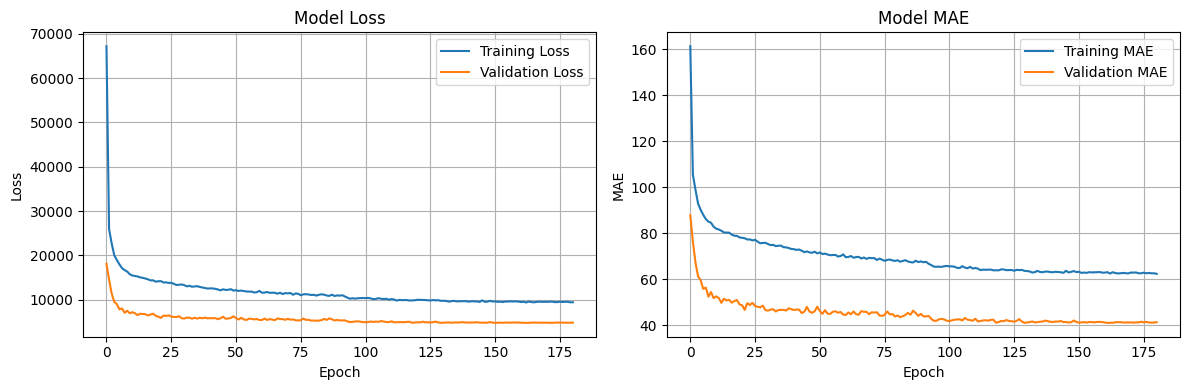

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Modelo mejorado con BatchNormalization
model = Sequential([
    Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),

    Dense(1)
])

# Optimizer con learning rate adaptativo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Callbacks para mejor entrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluación
loss, mae = model.evaluate(X_test, y_test)
print(f"\n🎯 Test MAE: {mae:.2f}")

# Predicciones
bikes["predicted_total"] = model.predict(scaler.transform(X))

# Guardar predicciones
bikes["predicted_total"].head(384).to_csv("bike-predictions.csv", index=False, header=['total_rentals'])
print("✅ CSV export complete!")

# Visualización opcional del entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()